In [1]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

import pandas as pd
from dotenv import load_dotenv


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

CPU times: user 292 ms, sys: 85 ms, total: 377 ms
Wall time: 630 ms


True

In [2]:
df_reviews = pd.read_csv(
    config.interim_dir / "olist_order_reviews_translated_label_merged.csv",
)

df_orders = pd.read_csv(config.interim_dir / "olist_orders_customer_merged.csv")
df_item_products = pd.read_csv(
    config.interim_dir / "olist_item_product_seller_merged.csv"
)
df_orders_item_products_merged = pd.merge(
    df_orders, df_item_products, on="order_id", how="left"
)
assert (
    df_orders_item_products_merged["order_id"].nunique()
    == df_orders["order_id"].nunique()
)
df_orders_item_products_review_merged = pd.merge(
    df_orders_item_products_merged,
    df_reviews,
    on="order_id",
    how="left",
)
assert (
    df_orders_item_products_review_merged["order_id"].nunique()
    == df_orders_item_products_merged["order_id"].nunique()
)

In [4]:
df_review_no_null = (
    df_reviews.dropna(subset=["review_comment_message_en"])[
        [
            "review_id",
            "review_comment_message_en",
            "label_score",
            "label_translated",
            "modified_review_score",
            "meaningful_words",
        ]
    ]
    .drop_duplicates()
    .reset_index()
    .drop(columns=["index"])
)
df_reviews_unique = df_reviews[
    [
        "review_id",
        "review_comment_message_en",
        "label_score",
        "label_translated",
        "modified_review_score",
        "meaningful_words",
    ]
].drop_duplicates()
print(f"df_reviews_unique.shape: {df_reviews_unique.shape}")
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_reviews_unique.shape: (98410, 6)
df_review_no_null.shape: (40650, 6)


## クラスタリング (util.community_detection)

- 全体
    - 前半と後半
        - 全商品カテゴリ
        - 成長鈍化商品カテゴリ
- negativeに限定
    - 前半と後半
        - 全商品カテゴリ
        - 成長鈍化商品カテゴリ

### 全てのレビューをクラスタリング

In [5]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    df_review_no_null["review_comment_message_en"].values.tolist()
)

In [7]:
clusters = util.community_detection(
    embeddings,
    min_community_size=50,
    threshold=0.90,
)
for i, cluster in enumerate(clusters):
    print(f"\nCluster {i + 1}, # Elements: {len(cluster)}")
    for sentence_id in cluster:
        print(
            f"\t{df_review_no_null['review_comment_message_en'].values.tolist()[sentence_id]}"
        )


Cluster 1, # Elements: 603
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.
	Very good.


In [9]:
print(f"num of clusters: {len(clusters)}")
total_num = 0
for i in clusters:
    total_num += len(i)
print(f"total_num: {total_num}")

num of clusters: 34
total_num: 4346


### negativeレビューをクラスタリング

In [15]:
df_review_no_null_negative = df_review_no_null.query("label_translated == 'Negative'")
print(f"df_review_no_null_negative.shape: {df_review_no_null_negative.shape}")

df_review_no_null_negative.shape: (8130, 6)


In [27]:
negative_embeddings = model.encode(
    df_review_no_null_negative["review_comment_message_en"].values.tolist()
)
negative_clusters = util.community_detection(
    negative_embeddings,
    min_community_size=50,
    threshold=0.70,
)


In [28]:
for i, cluster in enumerate(negative_clusters):
    print(f"\nCluster {i + 1}, # Elements: {len(cluster)}")
    for sentence_id in cluster:
        print(
            f"\t{df_review_no_null_negative['review_comment_message_en'].values.tolist()[sentence_id]}"
        )


Cluster 1, # Elements: 638
	I still haven't received the product, the delivery deadline has passed and nothing yet.
	I still haven't received the product and the delivery deadline has already passed.
	The delivery deadline has passed and I still haven't received the product.
	I STILL HAVEN'T RECEIVED THE PRODUCT AND THE DELIVERY DATE HAS PASSED.
	The delivery deadline has passed and I still have not received the product.
	I still haven't received my product; the delivery deadline was until 03/23, and it hasn't arrived yet.
	Delay in delivery, I still haven't received the product.
	I still haven't received the product, and the delivery is overdue!
	I still haven't received my product, the deadline was until today, but nothing yet.
	I still haven't received the product, but it's due to the postal delay. Still waiting...
	I STILL HAVEN'T RECEIVED MY PRODUCT, THE DELIVERY DEADLINE HAS PASSED SINCE 02/20/2018.
	I still haven't received the product, even though the expected delivery time ha

In [29]:
print(f"num of clusters: {len(negative_clusters)}")
total_num = 0
for i in negative_clusters:
    total_num += len(i)
print(f"total_num: {total_num}")
print(f"cover ratio: {total_num / df_review_no_null_negative.shape[0]}")

num of clusters: 26
total_num: 2610
cover ratio: 0.3210332103321033


In [31]:
df_orders_item_products_review_merged["is_delivery_delayed"].value_counts()

is_delivery_delayed
False    105336
True       8756
Name: count, dtype: int64

In [33]:
df_review_no_null_not_delayed_negative = (
    df_orders_item_products_review_merged.query(
        "is_delivery_delayed == False & label_translated == 'Negative'"
    )
    .dropna(subset=["review_comment_message_en"])[
        [
            "review_id",
            "review_comment_message_en",
            "label_score",
            "label_translated",
            "modified_review_score",
            "meaningful_words",
        ]
    ]
    .drop_duplicates()
)
print(
    f"df_review_no_null_not_delayed_negative.shape: {df_review_no_null_not_delayed_negative.shape}"
)


df_review_no_null_not_delayed_negative.shape: (5936, 6)


In [34]:
not_delayed_negative_embeddings = model.encode(
    df_review_no_null_not_delayed_negative["review_comment_message_en"].values.tolist()
)
not_delayed_negative_clusters = util.community_detection(
    not_delayed_negative_embeddings,
    min_community_size=50,
    threshold=0.70,
)


In [37]:
not_delayed_negative_embeddings.shape

(5936, 384)

In [35]:
for i, cluster in enumerate(not_delayed_negative_clusters):
    print(f"\nCluster {i + 1}, # Elements: {len(cluster)}")
    for sentence_id in cluster:
        print(
            f"\t{df_review_no_null_not_delayed_negative['review_comment_message_en'].values.tolist()[sentence_id]}"
        )


Cluster 1, # Elements: 268
	I did not receive my product.
	I did not receive my product.
	I did not receive my product.
	I did not receive my product.
	I did not receive my product.
	I DID NOT RECEIVE THE PRODUCT.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receive the product.
	I did not receiv

In [36]:
print(f"num of clusters: {len(not_delayed_negative_clusters)}")
total_num = 0
for i in not_delayed_negative_clusters:
    total_num += len(i)
print(f"total_num: {total_num}")
print(f"cover ratio: {total_num / df_review_no_null_not_delayed_negative.shape[0]}")

num of clusters: 14
total_num: 1222
cover ratio: 0.20586253369272237


## クラスタリング (umap+hdbscan)

In [51]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(
    df_review_no_null["review_comment_message_en"].values.tolist()
)

array([[-0.08540118,  0.10395774,  0.09349585, ...,  0.01058165,
        -0.08484345,  0.03071799],
       [ 0.00332832,  0.06827421,  0.04191022, ..., -0.01981435,
        -0.05380649,  0.01751252],
       [-0.12791935,  0.02060129, -0.07195029, ..., -0.02410332,
         0.1256146 ,  0.01185133],
       ...,
       [-0.02987073,  0.00764188,  0.03370086, ..., -0.09665258,
        -0.00808565,  0.01431215],
       [-0.06038512,  0.06837215, -0.05195542, ..., -0.04585287,
        -0.0126798 ,  0.03985866],
       [ 0.05763007,  0.0109417 , -0.06884737, ..., -0.06471014,
         0.05912761,  0.03873218]], dtype=float32)

/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/shim-kojio/Desktop/ey_sat_lab/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


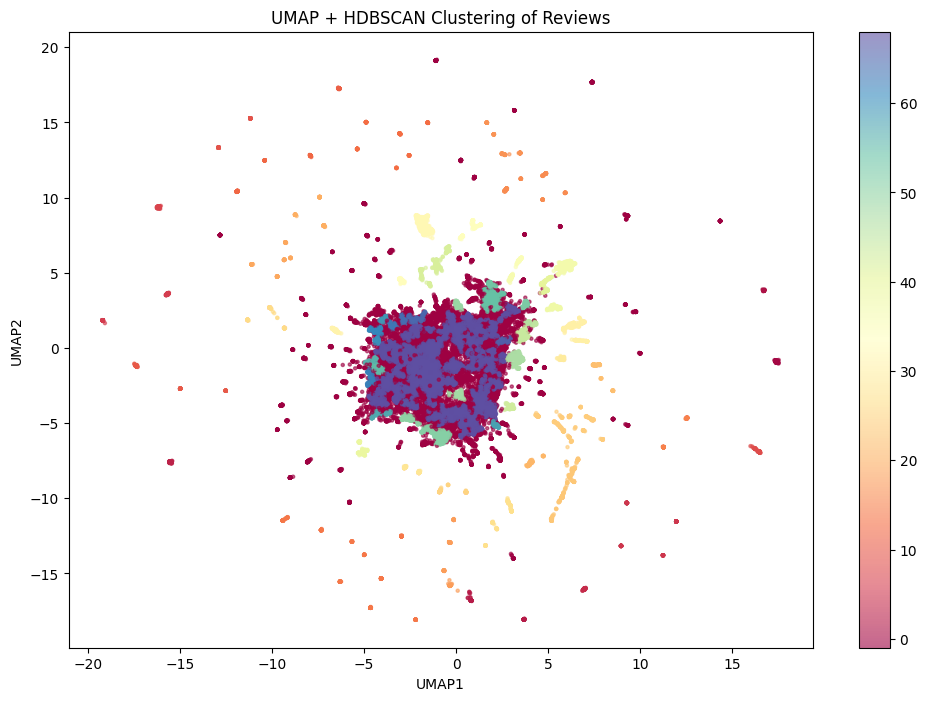

Number of clusters: 69
Number of noise points: 8435


In [55]:
import hdbscan
import matplotlib.pyplot as plt
import umap

# UMAP で次元削減
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="cosine")

# embeddingsを2次元に削減
umap_embeddings = reducer.fit_transform(embeddings)

# HDBSCANでクラスタリング
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=10,
    metric="euclidean",
    cluster_selection_epsilon=0.1,
)

# クラスタリングの実行
cluster_labels = clusterer.fit_predict(umap_embeddings)

# 可視化
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    umap_embeddings[:, 0],
    umap_embeddings[:, 1],
    c=cluster_labels,
    cmap="Spectral",
    s=5,
    alpha=0.6,
)
plt.colorbar(scatter)
plt.title("UMAP + HDBSCAN Clustering of Reviews")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

# クラスター数とノイズポイント（-1のラベル）の数を表示
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

In [ ]:
cluster_labels